In [1]:
import mira

In [2]:
mira.topics.ExpressionTopicModel.load('../../cellgen2/data/revised/checkup/scaffold0.test3-4.mira_RNA.h5.rna-model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.


AttributeError: 'ExpressionTopicModel' object has no attribute 'num_covariates'

/Users/alynch/opt/miniconda3/envs/noR/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


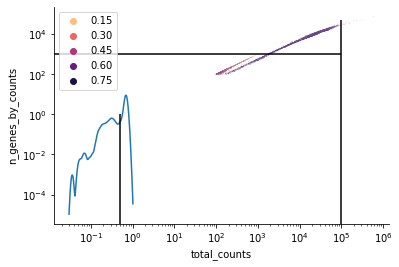

In [25]:
import scanpy as sc
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os

data = 'data/processing_test/bulk.peakcounts.h5ad'
min_peaks = 1000
max_counts = 1e5
min_frip = 0.5
resolution = 0.1
min_fragments = 4e6
outdir = 'data/processing_test/clusters/'
report_dir = 'data/processing_test/'
num_components = 15

data = anndata.read_h5ad(data)

sc.pp.filter_cells(data, min_genes=100)
sc.pp.calculate_qc_metrics(data, log1p=False, inplace=True)
data.obs['FRIP'] = data.obs.total_counts/(data.obs.n_background_peaks + data.obs.total_counts)

ax = sns.scatterplot(data = data.obs, s = 0.2, color = 'black', palette='magma_r',
                     x='total_counts', y = 'n_genes_by_counts', hue = 'FRIP')
ax.set(yscale = 'log', xscale = 'log')
ax.vlines(max_counts, ymin = 0, ymax = 5e4, color = 'black')
ax.hlines(min_peaks, xmin = 0, xmax = 1e5, color = 'black')
sns.despine()
plt.savefig(os.path.join(report_dir, 'readdepth_distribution.png'))

ax = sns.kdeplot(data = data.obs, x = 'FRIP', )
ax.vlines(min_frip, ymin = 0, ymax = 1, color = 'black')
sns.despine()
plt.savefig(os.path.join(report_dir, 'FRIP.png'))

data = data[(data.obs.n_genes_by_counts > min_peaks) \
            & (data.obs.total_counts < max_counts) \
            & (data.obs.FRIP > min_frip)
           ]

data.layers['binary'] = data.X.copy()
data.layers['binary'].data = np.ones_like(data.layers['binary'].data)

lsi = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=50)),
    ('scaler', StandardScaler())
]).fit(data.layers['binary'])

sns.lineplot(
    y = np.cumsum(lsi.steps[1][1].explained_variance_),
    x = np.arange(50)
)
sns.despine()
os.path.join(report_dir, 'component_explained_variance.png')

data.obsm['X_pca'] = lsi.transform(data.layers['binary'])[:, :num_components]

sc.pp.neighbors(data)
sc.tl.umap(data, min_dist=0.1)
sc.tl.leiden(data, resolution = resolution)

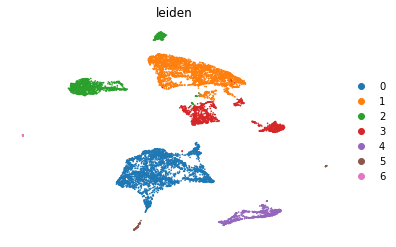

In [30]:
sc.pl.umap(data, color = 'leiden', show = False, frameon = False)
plt.savefig(os.path.join(report_dir, 'leiden_UMAP.png'))

In [27]:
groupsize = data.obs.groupby('leiden')['total_counts'].sum()
groups = groupsize[groupsize >= min_fragments].index.values

In [29]:
for group in groups:
    with open(os.path.join(outdir, '{}.barcodes.txt'.format(str(group))), 'w') as f:
        print(*data.obs_names[data.obs.leiden == group], sep = '\n', file = f)

In [33]:
def get_cluster_barcodes(
    min_peaks = 1000,
    max_counts = 1e5,
    min_frip = 0.5,
    resolution = 0.1,
    min_fragments = 4e6,
    num_components = 15,*,
    data, outdir, report_dir
    ):

    data = anndata.read_h5ad(data)

    sc.pp.filter_cells(data, min_genes=100)
    sc.pp.calculate_qc_metrics(data, log1p=False, inplace=True)
    data.obs['FRIP'] = data.obs.total_counts/(data.obs.n_background_peaks + data.obs.total_counts)

    ax = sns.scatterplot(data = data.obs, s = 0.2, color = 'black', palette='magma_r',
                        x='total_counts', y = 'n_genes_by_counts', hue = 'FRIP')
    ax.set(yscale = 'log', xscale = 'log')
    ax.vlines(max_counts, ymin = 0, ymax = 5e4, color = 'black')
    ax.hlines(min_peaks, xmin = 0, xmax = 1e5, color = 'black')
    sns.despine()
    plt.savefig(os.path.join(report_dir, 'readdepth_distribution.png'))

    del ax
    ax = sns.kdeplot(data = data.obs, x = 'FRIP')
    ax.vlines(min_frip, ymin = 0, ymax = 1, color = 'black')
    sns.despine()
    plt.savefig(os.path.join(report_dir, 'FRIP.png'))
    del ax

    data = data[(data.obs.n_genes_by_counts > min_peaks) \
                & (data.obs.total_counts < max_counts) \
                & (data.obs.FRIP > min_frip)
            ]

    data.layers['binary'] = data.X.copy()
    data.layers['binary'].data = np.ones_like(data.layers['binary'].data)

    lsi = Pipeline([
        ('tfidf', TfidfTransformer()),
        ('svd', TruncatedSVD(n_components=50)),
        ('scaler', StandardScaler())
    ]).fit(data.layers['binary'])

    sns.lineplot(
        y = np.cumsum(lsi.steps[1][1].explained_variance_),
        x = np.arange(50)
    )
    sns.despine()
    os.path.join(report_dir, 'component_explained_variance.png')

    data.obsm['X_pca'] = lsi.transform(data.layers['binary'])[:, :num_components]

    sc.pp.neighbors(data)
    sc.tl.umap(data, min_dist=0.1)
    sc.tl.leiden(data, resolution = resolution)

    sc.pl.umap(data, color = 'leiden', show = False, frameon = False)
    plt.savefig(os.path.join(report_dir, 'leiden_UMAP.png'))

    groupsize = data.obs.groupby('leiden')['total_counts'].sum()
    groups = groupsize[groupsize >= min_fragments].index.values

    print('Found {} clusters.'.format(len(groups)))
    for group in groups:
        with open(os.path.join(outdir, '{}.barcodes.txt'.format(str(group))), 'w') as f:
            print(*data.obs_names[data.obs.leiden == group], sep = '\n', file = f)

/Users/alynch/opt/miniconda3/envs/noR/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Found 6 clusters.


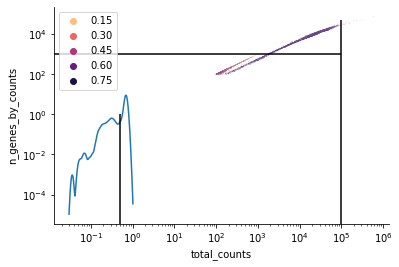

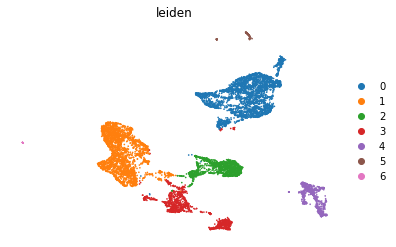

In [34]:
get_cluster_barcodes(
    data = 'data/processing_test/bulk.peakcounts.h5ad', 
    outdir = 'data/processing_test/clusters/', 
    report_dir = 'data/processing_test/'
)